In [67]:
# On met ici toutes les bibliothèques utilisées pendant le projet
# Si nécessaire, installer les modules manquants en fonction des erreurs
# que cette node peut produire (par exemple, tensorflow et pytorch)

import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import s3fs
import tensorflow as tf
import zipfile
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

In [8]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [9]:
# Lister les challenges
fs.ls("gvimont/diffusion/hackathon-minarm-2024")


['gvimont/diffusion/hackathon-minarm-2024/AIVSAI',
 'gvimont/diffusion/hackathon-minarm-2024/Acoustique',
 'gvimont/diffusion/hackathon-minarm-2024/Similarité']

In [10]:
# Lister les fichiers d'un challenge
fs.ls("gvimont/diffusion/hackathon-minarm-2024/Acoustique")

['gvimont/diffusion/hackathon-minarm-2024/Acoustique/LivingRoom_preprocessed_hack.zip']

In [11]:
# Download the data
PATH_IN = 'gvimont/diffusion/hackathon-minarm-2024/Acoustique/LivingRoom_preprocessed_hack.zip'
fs.download(PATH_IN, 'data/LivingRoom_preprocessed_hack.zip')

[None]

In [12]:
# Décompresser les données
with zipfile.ZipFile("data/LivingRoom_preprocessed_hack.zip","r") as zip_file:
    zip_file.extractall("data/")

In [13]:
# Chargement des jeux de données de RIR
deconvolved_human1 = np.load('data/LivingRoom_preprocessed_hack/Human1/deconvoled_trim.npy')
deconvolved_human2 = np.load('data/LivingRoom_preprocessed_hack/Human2/deconvoled_trim.npy')
deconvolved_empty = np.load('data/LivingRoom_preprocessed_hack/Empty/deconvolved.npy')

In [14]:
# Calculer les niveaux RMS pour chaque datapoint de chaque micro
niveaux_rms_human1 = []
niveaux_rms_human2 = []
for i in range (4):
    niveaux_rms_h1_i = np.sqrt(np.mean(deconvolved_human1[:,i,:]**2, axis=(1)))
    niveaux_rms_h2_i = np.sqrt(np.mean(deconvolved_human2[:,i,:]**2, axis=(1)))
    niveaux_rms_human1.append(niveaux_rms_h1_i)
    niveaux_rms_human2.append(niveaux_rms_h2_i)

niveaux_rms_human1 = np.array(niveaux_rms_human1)
niveaux_rms_human2 = np.array(niveaux_rms_human2)

# Vérifier les dimensions de niveaux_rms
print("Dimensions des données originales du 1er humain: ", deconvolved_human1.shape)
print("Dimensions de niveaux_rms du 1er humain:", niveaux_rms_human1.shape)
print("Dimensions des données originales du 2eme humain: ", deconvolved_human2.shape)
print("Dimensions de niveaux_rms du 2eme humain:", niveaux_rms_human2.shape)

Dimensions des données originales du 1er humain:  (1000, 4, 667200)
Dimensions de niveaux_rms du 1er humain: (4, 1000)
Dimensions des données originales du 2eme humain:  (104, 4, 667200)
Dimensions de niveaux_rms du 2eme humain: (4, 104)


In [15]:
# Chargement des jeux de données de positions
centroid_human1 = np.load('data/LivingRoom_preprocessed_hack/Human1/centroid.npy')
centroid_human2 = np.load('data/LivingRoom_preprocessed_hack/Human2/centroid.npy')

In [16]:
# Vérification des shapes des données récupérées
print(centroid_human1.shape)
print(centroid_human2.shape)

(1000, 2)
(104, 2)


In [17]:
# Mise en commun de human1 et human2 en un seul jeu de donnée pour les RMS et les positions
niveaux_rms = np.concatenate((niveaux_rms_human1, niveaux_rms_human2), axis=1)

# on transpose les arrays avec .T pour éviter les conflits pendant la mise en commun,
# puis on retranspose derrière
positions = np.concatenate((centroid_human1.T, centroid_human2.T), axis=1)
positions = positions.T

#vérification des shapes de la mise en commun
print(niveaux_rms.shape)
print(positions.shape)

(4, 1104)
(1104, 2)


In [70]:
# Préparation des données pour l'entrainement

# X : données de niveaux RMS (4, N_datapoints)
# y : données de position (N_datapoints, 2)

# Diviser les données en ensembles d'entraînement et de test
# On transpose X pour avoir N_datapoints en premier pour les deux datasets
X_train, X_test, y_train, y_test = train_test_split(niveaux_rms.T, positions, test_size=0.2, random_state=42)

# Réduire les données à 3, 2 et 1 micro pour faire des comparaisons avec le nombre de micros
# Division des données au nombre de micros respectifs en ensembles d'entraînement et de test également
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(niveaux_rms[0:3,:].T, positions, test_size=0.2, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(niveaux_rms[0:2,:].T, positions, test_size=0.2, random_state=42)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(niveaux_rms[0:1,:].T, positions, test_size=0.2, random_state=42)

# Vérification que les données divisées aient bien la bonne shape pour s'entrainer et tester les modèles au nombre de micros voulus
# Rappel: Shape des données = (N_datapoints, N_micros)
print(X_train.shape)
print(X_train_3.shape)
print(X_train_2.shape)
print(X_train_1.shape)


(883, 4)
(883, 3)
(883, 2)
(883, 1)


## Algorithmes utilisés:
 - KNN 
 - Linear Regression
 - CNN classique
 - VGGish

KNN et la régression linéaire étant tous les deux utilisés dans le papier, ils seront comparés aux résultats du livre pour le nombre de microphones correspondants. CNN ne sera utilisé qu'avec 4 microphones, pas moins.

In [58]:
# Implémentation de KNN

# Choix des voisins: 4, car c'est celui qui minimise la distance moyenne pour les 4 micros
# On considère les 4 micros comme le "standard" pour l'entrainement et la création des modèles qui suivent

knn = KNeighborsRegressor(n_neighbors=4)
knn_3 = KNeighborsRegressor(n_neighbors=4)
knn_2 = KNeighborsRegressor(n_neighbors=4)
knn_1 = KNeighborsRegressor(n_neighbors=4)

# Entrainement du modèle knn pour 4 à 1 micro
knn.fit(X_train, y_train)
knn_3.fit(X_train_3, y_train_3)
knn_2.fit(X_train_2, y_train_2)
knn_1.fit(X_train_1, y_train_1)

# Prediction des positions pour chaque knn
predictions = knn.predict(X_test)
predictions_3 = knn_3.predict(X_test_3)
predictions_2 = knn_2.predict(X_test_2)
predictions_1 = knn_1.predict(X_test_1)

In [59]:
# Evaluation (moyenne de la distance des prédictions par rapport aux distances réelles)
# On divise par 10 car les résultats sont en milimètres (nous voulons des centimètres pour comparer avec le livre)
knn_eval = np.mean(np.abs(y_test - predictions)) /10
knn_eval_3 = np.mean(np.abs(y_test_3 - predictions_3)) /10
knn_eval_2 = np.mean(np.abs(y_test_2 - predictions_2)) /10
knn_eval_1 = np.mean(np.abs(y_test_1 - predictions_1)) /10

# Calcul de l'ecart-type, pour indiquer l'écart des prédictions par rapport à la moyenne
knn_std = np.std(np.abs(y_test - predictions)) /10
knn_std_3 = np.std(np.abs(y_test_3 - predictions_3)) /10
knn_std_2 = np.std(np.abs(y_test_2 - predictions_2)) /10
knn_std_1 = np.std(np.abs(y_test_1 - predictions_1)) /10

# Comparaison des résultats pour le nombre de micros pour les KNN
# Pour comparer les résultats au papier, on passe les données en cm
# On arrondit également à deux chiffres après la virgule
print("KNN distance moyenne par rapport à la position réelle pour 4 microphones:", np.round(knn_eval, 2), "cm, écart-type:", np.round(knn_std, 2), "cm")
print("KNN distance moyenne par rapport à la position réelle pour 3 microphones:", np.round(knn_eval_3, 2), "cm, écart-type:", np.round(knn_std_3, 2), "cm")
print("KNN distance moyenne par rapport à la position réelle pour 2 microphones:", np.round(knn_eval_2, 2), "cm, écart-type:", np.round(knn_std_2, 2), "cm")
print("KNN distance moyenne par rapport à la position réelle pour 1 microphone:", np.round(knn_eval_1, 2), "cm, écart-type:", np.round(knn_std_1, 2), "cm")

KNN distance moyenne par rapport à la position réelle pour 4 microphones: 62.4 cm, écart-type: 64.25 cm
KNN distance moyenne par rapport à la position réelle pour 3 microphones: 79.55 cm, écart-type: 71.57 cm
KNN distance moyenne par rapport à la position réelle pour 2 microphones: 93.68 cm, écart-type: 68.5 cm
KNN distance moyenne par rapport à la position réelle pour 1 microphone: 103.44 cm, écart-type: 72.9 cm


In [60]:
# Implémentation de régression linéaire

# Création du modèle de regression linéaire
linear_regression = LinearRegression()
linear_regression_3 = LinearRegression()
linear_regression_2 = LinearRegression()
linear_regression_1 = LinearRegression()

# Entrainement des modèles
linear_regression.fit(X_train, y_train)
linear_regression_3.fit(X_train_3, y_train_3)
linear_regression_2.fit(X_train_2, y_train_2)
linear_regression_1.fit(X_train_1, y_train_1)

# Predictions des positions pour chaque modèle
predictions = linear_regression.predict(X_test)
predictions_3 = linear_regression_3.predict(X_test_3)
predictions_2 = linear_regression_2.predict(X_test_2)
predictions_1 = linear_regression_1.predict(X_test_1)

In [61]:
# Evaluation (moyenne de la distance des prédictions par rapport aux distances réelles)
# On divise par 10 car les résultats sont en milimètres (nous voulons des centimètres pour comparer avec le livre)
lr_eval = np.mean(np.abs(y_test - predictions)) /10
lr_eval_3 = np.mean(np.abs(y_test_3 - predictions_3)) /10
lr_eval_2 = np.mean(np.abs(y_test_2 - predictions_2)) /10
lr_eval_1 = np.mean(np.abs(y_test_1 - predictions_1)) /10

# Calcul de l'ecart-type, pour indiquer l'écart des prédictions par rapport à la moyenne
lr_std = np.std(np.abs(y_test - predictions)) /10
lr_std_3 = np.std(np.abs(y_test_3 - predictions_3)) /10
lr_std_2 = np.std(np.abs(y_test_2 - predictions_2)) /10
lr_std_1 = np.std(np.abs(y_test_1 - predictions_1)) /10

# Comparaison des résultats pour le nombre de micros
# On arrondit également à deux chiffres après la virgule
print("Linear Regression distance moyenne par rapport à la position réelle pour 4 microphones:", np.round(lr_eval, 2), "cm, écart-type:", np.round(lr_std, 2), "cm")
print("Linear Regression distance moyenne par rapport à la position réelle pour 3 microphones:", np.round(lr_eval_3, 2), "cm, écart-type:", np.round(lr_std_3, 2), "cm")
print("Linear Regression distance moyenne par rapport à la position réelle pour 2 microphones:", np.round(lr_eval_2, 2), "cm, écart-type:", np.round(lr_std_2, 2), "cm")
print("Linear Regression distance moyenne par rapport à la position réelle pour 1 microphone:", np.round(lr_eval_1, 2), "cm, écart-type:", np.round(lr_std_1, 2), "cm")

Linear Regression distance moyenne par rapport à la position réelle pour 4 microphones: 95.93 cm, écart-type: 63.78 cm
Linear Regression distance moyenne par rapport à la position réelle pour 3 microphones: 100.03 cm, écart-type: 65.88 cm
Linear Regression distance moyenne par rapport à la position réelle pour 2 microphones: 101.67 cm, écart-type: 65.72 cm
Linear Regression distance moyenne par rapport à la position réelle pour 1 microphone: 104.03 cm, écart-type: 64.52 cm


### Comparaison des résultats en fonction du nombre de micros avec les résultats du papier sur les modèles en commun
Comme on peut le constater, en mettant nos résultats dans le même format que ceux du papier (en passant de mm en cm), on peut vérifier que nos résultats sont comparables à ceux du papier en terme d'ordre de grandeur, comme l'illustre le plot de comparaison de la prochaine node.

Similairement, on remarque que le nombre de micros a une influence plus ou moins grande sur la précision des prédictions:
On voit clairement que, bien que le KNN soit le plus précis pour 4 micros, il est également celui qui montre un plus grand écart dans la précision des prédictions en baissant le nombre de microphones, alors que la régression linéaire reste relativement constante dans sa performance.

Peu importe le modèle, il est clair que la précision des prédictions est directement corrélée au nombre de micros utilisés.

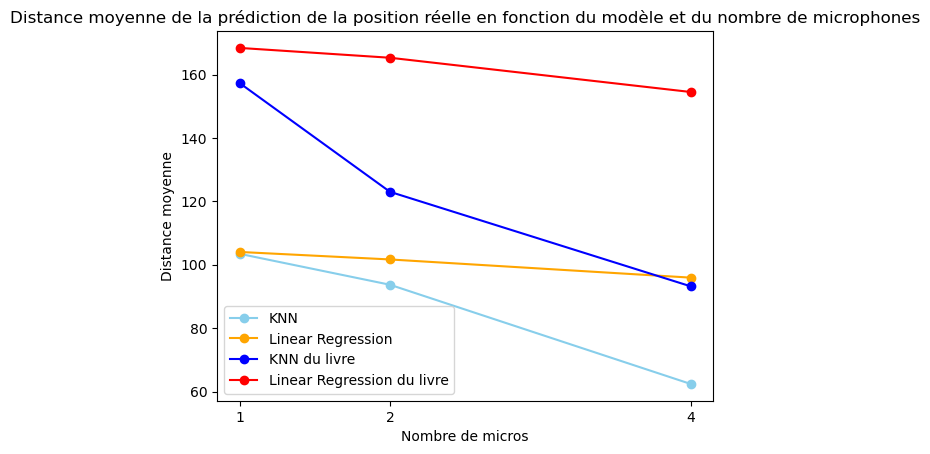

In [65]:
# Plot des résultats de KNN et Linear Regression face aux résultats du livre

# Création des arrays contenant les distances moyennes,
# de nos résultats et de ceux du livre
# Attention: nous ne mettons pas nos résultats pour 3 micros car le livre non plus
knn_avg_dists = [knn_eval_1, knn_eval_2, knn_eval]
lr_avg_dists = [lr_eval_1, lr_eval_2, lr_eval]
knn_book = [157.3, 123.0, 93.2]
lr_book = [168.4, 165.3, 154.5]

# Simple array du nombres de microphones
microphone_counts = [1, 2, 4]

plt.plot(microphone_counts, knn_avg_dists, marker='o', color='skyblue', linestyle='-', label="KNN")
plt.plot(microphone_counts, lr_avg_dists, marker='o', color='orange', linestyle='-', label="Linear Regression")
plt.plot(microphone_counts, knn_book, marker='o', color='blue', linestyle='-', label="KNN du livre")
plt.plot(microphone_counts, lr_book, marker='o', color='red', linestyle='-', label="Linear Regression du livre")
plt.xticks(microphone_counts)
plt.xlabel('Nombre de micros')
plt.ylabel('Distance moyenne')
plt.title('Distance moyenne de la prédiction de la position réelle en fonction du modèle et du nombre de microphones')
plt.legend()
plt.show()

In [25]:
# Implementation CNN avec Tensorflow

# Definition de l'architecture du Convolution Neural Network
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((4, 1), input_shape=(4,)),
    tf.keras.layers.Conv1D(64, kernel_size=1, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')


/opt/mamba/lib/python3.11/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=10)


Epoch 1/50


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3892013.7500 - val_loss: 4062500.2500
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3867047.7500 - val_loss: 3999476.5000
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3721194.7500 - val_loss: 3810578.0000
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3573437.5000 - val_loss: 3450958.0000
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3226215.0000 - val_loss: 2946479.0000
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2500107.5000 - val_loss: 2407075.5000
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2201976.0000 - val_loss: 1965420.1250
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1818422.7500 - val_loss: 1699537.0000
Epoch 9/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1671894.2500 - val_loss: 1580463.3750
Epoch 10/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1653073.0000 - val_loss: 1533374.7500
Epoch 11/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

In [27]:
# Evaluate the model on the test set
#test_loss = model.evaluate(X_test_scaled, y_test)
#print("Test loss (MSE):", test_loss)

from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate predictions
predictions = model.predict(X_test)

# Calculate Euclidean distance between the predicted and actual positions
errors = np.sqrt(np.sum((y_test - predictions)**2, axis=1))
average_error = np.mean(errors)

print("Average Euclidean distance from actual positions: {:.2f} mm".format(average_error))



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Average Euclidean distance from actual positions: 1631.07 mm


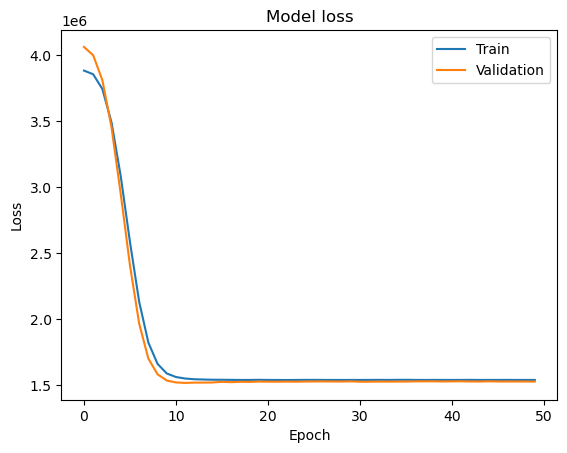

In [28]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Implementation VGGish
# Une partie du code est disponible sur le github du papier présenté


